# Advance Machine Learning - Assignment 1
#### Villa Giacomo 807462

## Importing Libraries

In [1]:
import keras 
from keras import backend as K
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.utils import plot_model
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.utils import resample
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

import pandas as pd

import numpy as np

from statistics import mean 

import matplotlib.pyplot as plt
%matplotlib inline

import math

import collections

import seaborn as sns

from ann_visualizer.visualize import ann_viz;

Using TensorFlow backend.


## Functions
The main functions used in the program are kept in the cell below. There is a function (binarization) which is not used but which I keep anyway for completeness.

In the function load_data is commented on the code for create new compound attributes; for the comments reason read the documentation.

In [2]:
def binarization(df, train):
    
    df = pd.concat([df, pd.get_dummies(df['EDUCATION'], prefix = 'EDUCATION', drop_first = False)],
                   axis = 1).drop(['EDUCATION'], axis = 1)
    df = pd.concat([df, pd.get_dummies(df['MARRIAGE'], prefix='MARRIAGE', drop_first=False)],
                   axis = 1).drop(['MARRIAGE'], axis = 1)
    if train:
        labels = df['default.payment.next.month']
        df.drop(labels=['default.payment.next.month'], axis=1,inplace = True)
        df['default.payment.next.month'] = labels 
    return df


def preprocess_data(X, scaler=None):
    """Preprocess input data by standardise features 
    by removing the mean and scaling to unit variance"""
    if not scaler:
        scaler = StandardScaler()
        scaler.fit(X)
    X = scaler.transform(X)
    return X, scaler

def load_data(path, train=True):
    text = pd.read_csv(path, encoding = "ISO-8859-2")
    df = pd.read_csv(path)
     
    '''count = collections.Counter(df['PAY_0'])
    print("THIS IS COUNT: ", count.keys())'''
    
    # DELETE COMMENTS TO DO THE BINARIZATION
    # df = binarization(df, train)
    
    # DELETE COMMENTS TO CREATE A NEW COMBINE ATTRIBUTE 
    # amoutPay = df['PAY_AMT1'] + df['PAY_AMT2'] + df['PAY_AMT3'] + df['PAY_AMT4'] + df['PAY_AMT5'] + df['PAY_AMT6']
    # amoutBill = df['BILL_AMT1'] + df['BILL_AMT2'] + df['BILL_AMT3'] + df['BILL_AMT4'] + df['BILL_AMT5'] + df['BILL_AMT6']
    
    # df['AmoutBill'] = amoutBill
    # df['AmoutPay'] = amoutPay
    
    # if train:
    #    labels = df['default.payment.next.month']
    #    df.drop(labels=['default.payment.next.month'], axis=1,inplace = True)
    #    df['default.payment.next.month'] = labels 
        
    X = df.values.copy()
    
    if train:
        np.random.shuffle(X)  
        X, labels = X[:, 1:-1].astype(np.float32), X[:, -1] 
        print_correlation_matrix(df)
        print_labels_number(df)
        
        return X, labels
    else:
        X, ids = X[:, 1:].astype(np.float32), X[:, 0].astype(str)
        return X, ids

def plot_history(network_history, index):
    plt.figure(figsize=(15,5)) 
    plt.xlabel('Epochs')
    plt.ylabel(index)
    plt.plot(network_history.history[index])

    plt.show()
    
def plot_train_vs_validate(history):
    plt.figure(figsize=(15,5))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    
    plt.figure(figsize=(15,5))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

def print_correlation_matrix(dataset):
    corr = dataset.corr()
    plt.subplots(figsize=(25, 25))
    plot = sns.heatmap(corr, xticklabels = corr.columns.values, yticklabels = corr.columns.values,
                      linewidths=.3, vmin=-1, vmax=1, annot=True)
    
def print_labels_number(dataset):
    fig1, ax1 = plt.subplots()
    number = dataset["default.payment.next.month"].value_counts()
    ax1.pie([number[0], number[1]], explode = (0, 0.2), labels = ['0', '1'] , autopct='%1.1f%%', 
            shadow=True, startangle=90)
    ax1.axis('equal')
    plt.show()
    
def get_class_performance(precision, recall, fscore, class_id):
    
    only_class_precision = [None]*10
    only_class_recall = [None]*10
    only_class_fscore = [None]*10
    
    for trip in range(0, 10):
        only_class_precision[trip] = precision[trip][class_id]
        only_class_recall[trip] = recall[trip][class_id]
        only_class_fscore[trip] = fscore[trip][class_id]
        
    return only_class_precision, only_class_recall, only_class_fscore

def create_model():
    model2 = Sequential()
    model2.add(Dense(64, input_shape=(dims,), activation='relu'))
    model2.add(Dropout(0.3, noise_shape=None, seed=None))
    model2.add(Dense(32, activation='relu'))
    model2.add(Dropout(0.3, noise_shape=None, seed=None))
    model2.add(Dense(1))
    model2.add(Activation('sigmoid'))
    model2.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['accuracy'])

    return model2

def plotConfusionMatrix(y_true, y_pred, classes, normalize, title, cmap = plt.cm.get_cmap("Blues")):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    # classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap= cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

    plt.show(ax)

## Loading Data
In this section I load data and make linear correlation matrix plot and pie chart about target.

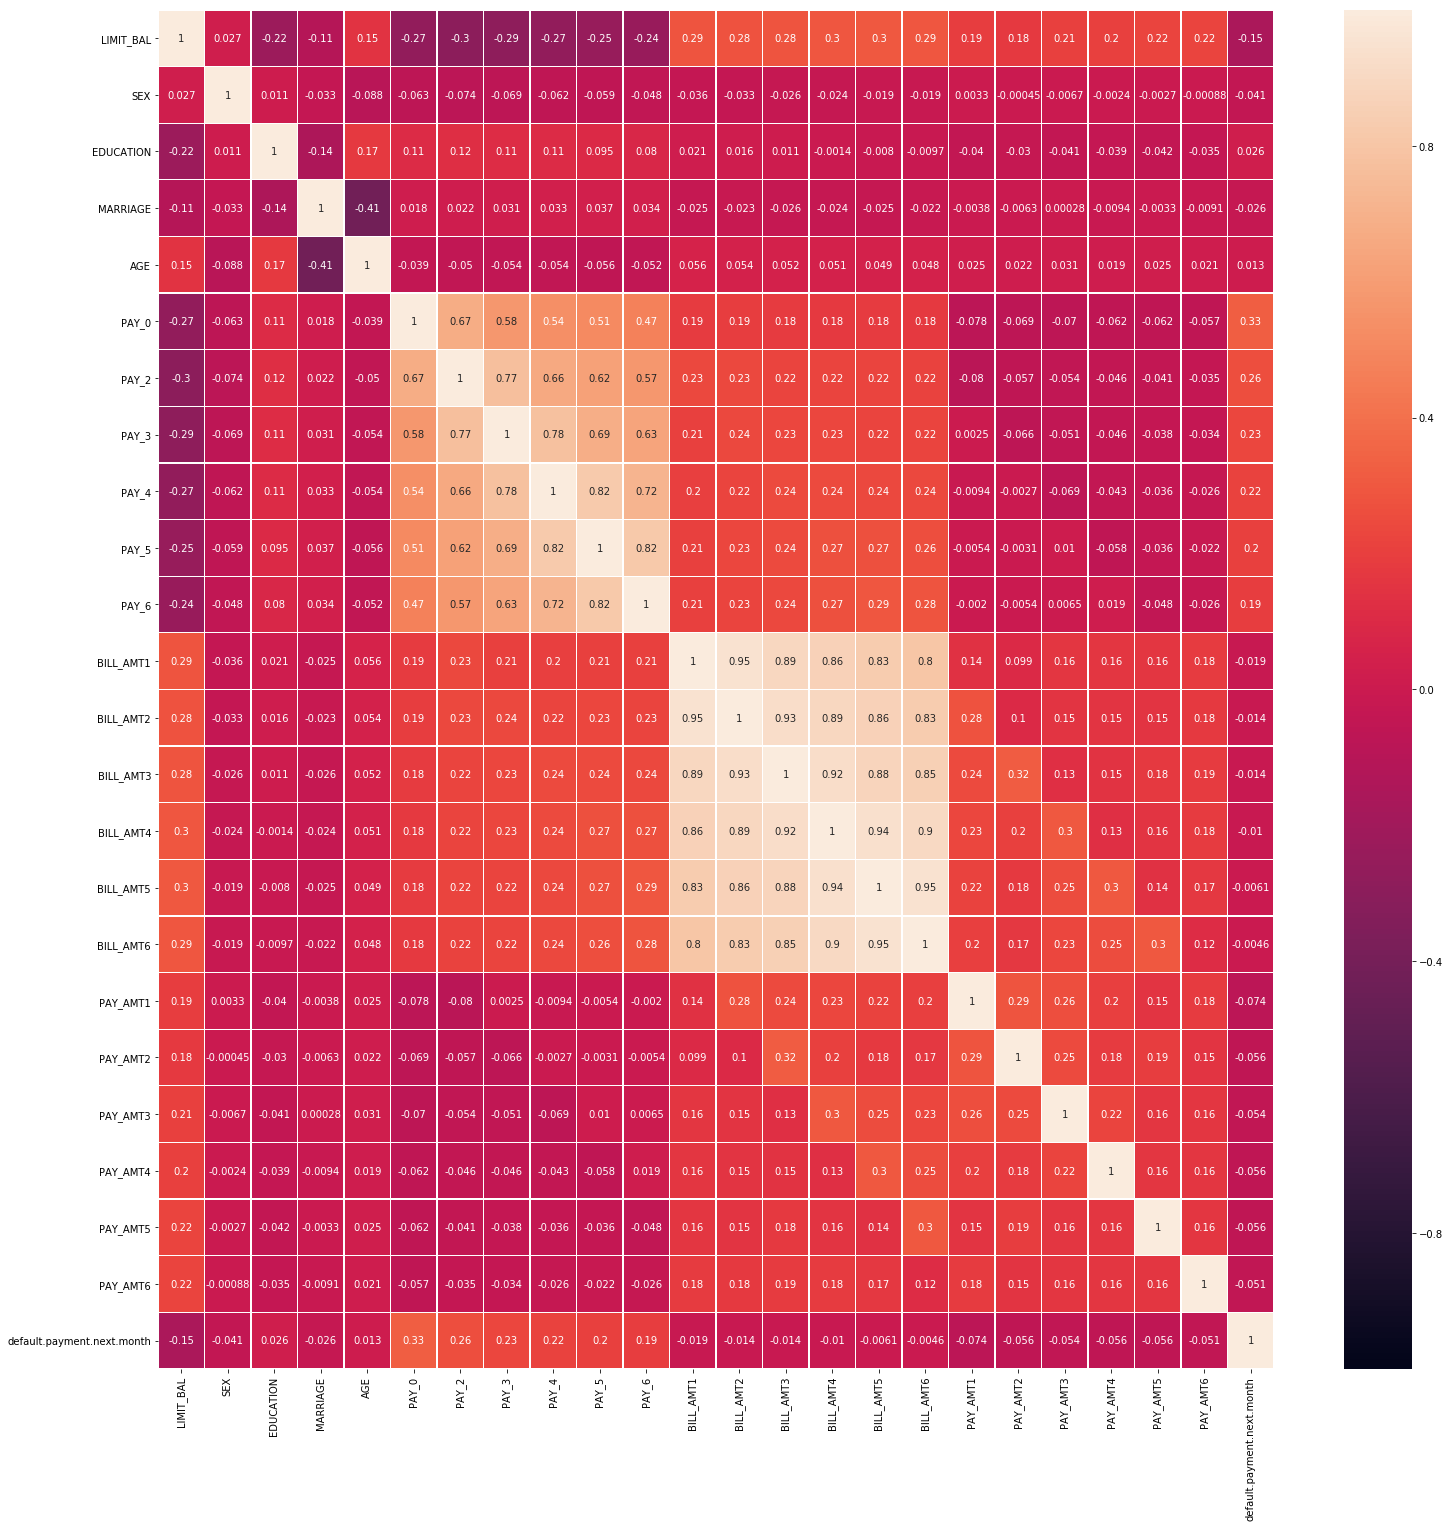

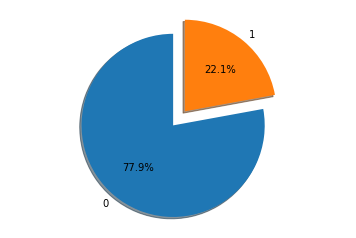

Dataset shape:  (27000, 22)
Labels shape:  (27000,)
Testset shape:  (3000, 22)


In [3]:
url_train = './train.csv'
url_test = './test.csv'

dataset, labels= load_data(url_train, train = True)
testset, ids = load_data(url_test, train = False)

print("Dataset shape: ", dataset.shape)
print("Labels shape: ", labels.shape)
print("Testset shape: ", testset.shape)

## Model Creation and 10 cross validation
In this section I make the 10CV inducing for every fold a neural network with 2 hidden layers (32 and 16 unit). I keep note about performance for successive analysis. 

FOLD NUMBER:  1
[[1684  419]
 [ 219  379]]


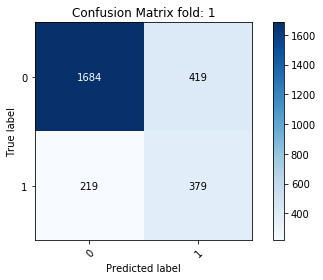

accuracy: 76.38%

FOLD NUMBER:  2
[[1674  429]
 [ 252  346]]


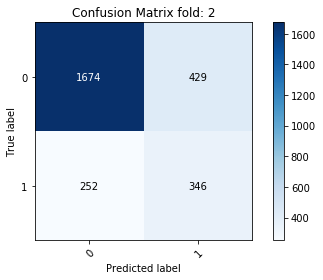

accuracy: 74.79%

FOLD NUMBER:  3
[[1701  402]
 [ 232  366]]


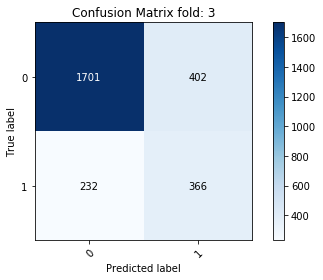

accuracy: 76.53%

FOLD NUMBER:  4


In [ ]:
kfold = StratifiedKFold(n_splits=10, shuffle=True)
cvscores = []
matrix = [None]*10
report = [None]*10
history_cross = [None]*10
precision = [None]*10
recall = [None]*10
f_score = [None]*10
f_score_avg = [None]*10


labels_predict = []
predict = []
fold = 0

dataset, scaler = preprocess_data(dataset)
dims = dataset.shape[1]

for train, test in kfold.split(dataset, labels):
    
    print("FOLD NUMBER: ", fold + 1)
    
    model2 = create_model()
    class_weights = class_weight.compute_class_weight('balanced', np.unique(labels[train]), labels[train])
    class_weights = dict(enumerate(class_weights))

    history_cross[fold] = model2.fit(dataset[train], labels[train], class_weight = class_weights,
                                     epochs=20, batch_size=256, verbose = 0)

    
    scores = model2.evaluate(dataset[test], labels[test], verbose = 0)
    labels_predict = model2.predict(dataset[test])
    
    for label_predict in labels_predict:
        if label_predict[0] > 0.5:
            predict.append(1)
        else:
            predict.append(0)
    
    plotConfusionMatrix(labels[test], predict, ['0', '1'], False,
                                       "Confusion Matrix fold: " + str(fold + 1), cmap= plt.cm.get_cmap("Blues"))
    report[fold] = classification_report(labels[test], predict)
    
    
    precision[fold] = [classification_report(labels[test], predict, output_dict = True)['0.0']['precision'], 
                       classification_report(labels[test], predict, output_dict = True)['1.0']['precision']]
    
    recall[fold] = [classification_report(labels[test], predict, output_dict = True)['0.0']['recall'], 
                    classification_report(labels[test], predict, output_dict = True)['1.0']['recall']]

    f_score[fold] = [classification_report(labels[test], predict, output_dict = True)['0.0']['f1-score'], 
                    classification_report(labels[test], predict, output_dict = True)['1.0']['f1-score']]
    
    f_score_avg[fold] = classification_report(labels[test], predict, output_dict = True)['weighted avg']['f1-score']
    
    predict.clear()
    fold += 1
    
    print("%s: %.2f%%" % (model2.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    print("")
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

## Performance Analysis
In this section I make available performance measurement about precision and recall; is available a sklearn report for each fold.

In [7]:
# Print performance report for each fold
print(report[9])

precision_0, recall_0, fscore_0 = get_class_performance(precision, recall, f_score, 0)
precision_1, recall_1, fscore_1 = get_class_performance(precision, recall, f_score, 1)

print("")
print("PRECISION MEAN FOR CLASS 0: ", round(mean(precision_0), 3))
print("PRECISION MEAN FOR CLASS 1: ", round(mean(precision_1), 3))
print("")
print("RECALL MEAN FOR CLASS 0: ", round(mean(recall_0), 3))
print("RECALL MEAN FOR CLASS 1: ", round(mean(recall_1), 3))
print("")
print("F1SCORE MEAN FOR CLASS 0: ", round(mean(fscore_0), 3))
print("F1SCORE MEAN FOR CLASS 1: ", round(mean(fscore_1), 3))
print("")
print("F1 AVG SCORE MEAN FOR FOLD: ", round(mean(f_score_avg), 3))

              precision    recall  f1-score   support

         0.0       0.88      0.81      0.85      2102
         1.0       0.48      0.60      0.54       597

   micro avg       0.77      0.77      0.77      2699
   macro avg       0.68      0.71      0.69      2699
weighted avg       0.79      0.77      0.78      2699


PRECISION MEAN FOR CLASS 0:  0.878
PRECISION MEAN FOR CLASS 1:  0.47

RECALL MEAN FOR CLASS 0:  0.806
RECALL MEAN FOR CLASS 1:  0.607

F1SCORE MEAN FOR CLASS 0:  0.84
F1SCORE MEAN FOR CLASS 1:  0.529

F1 AVG SCORE MEAN FOR FOLD:  0.771


#### In this section I plot the measurement previously shown

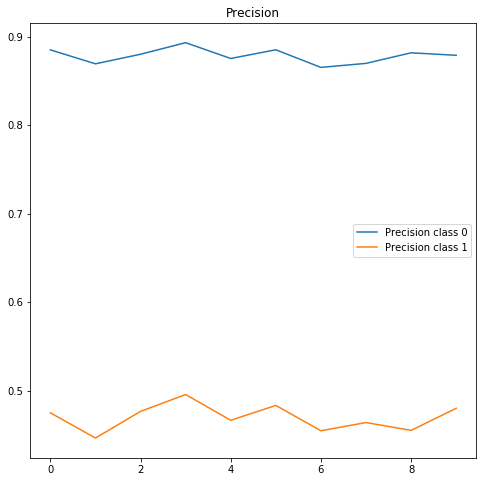

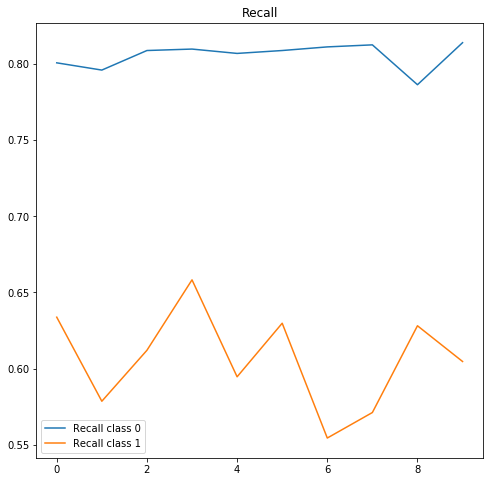

ACCURACY FOR EACH FOLD
FOLD NUMBER:  1


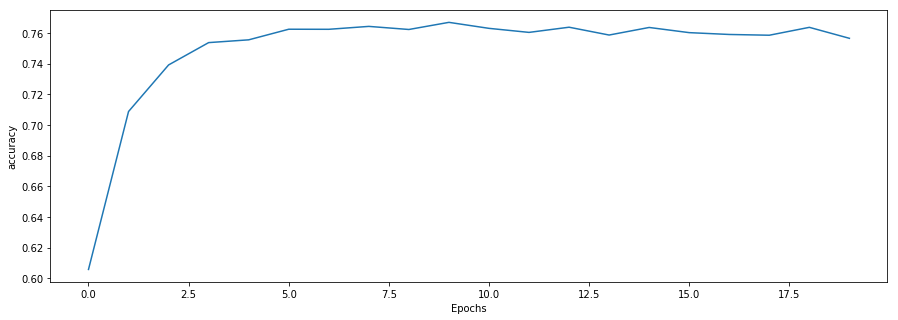

FOLD NUMBER:  2


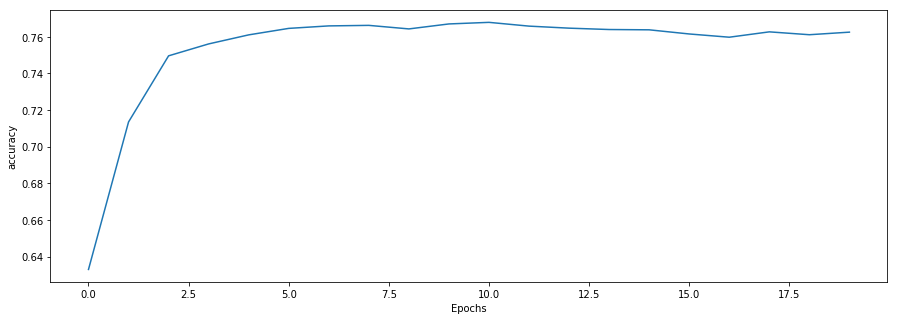

FOLD NUMBER:  3


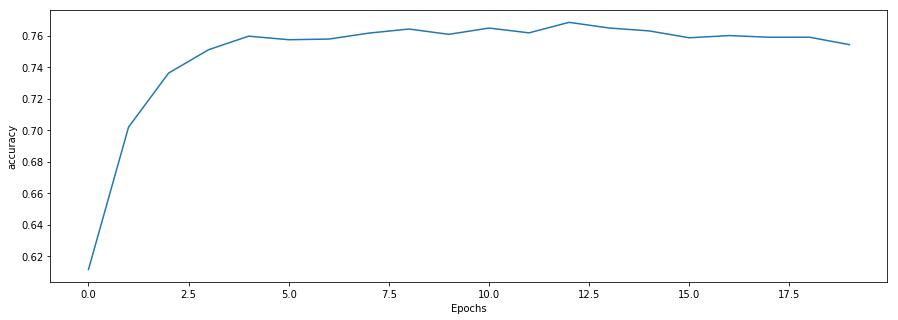

FOLD NUMBER:  4


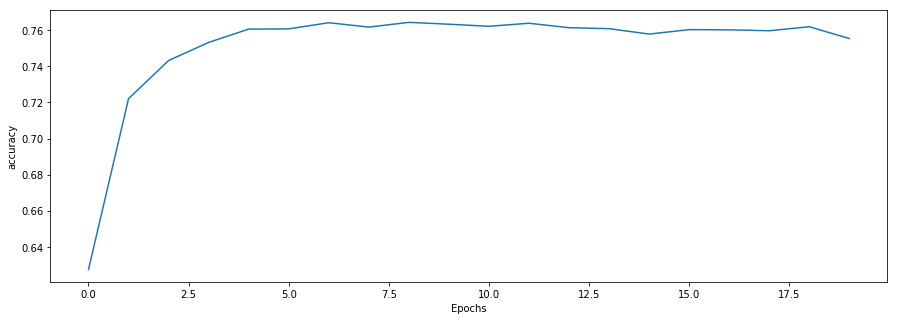

FOLD NUMBER:  5


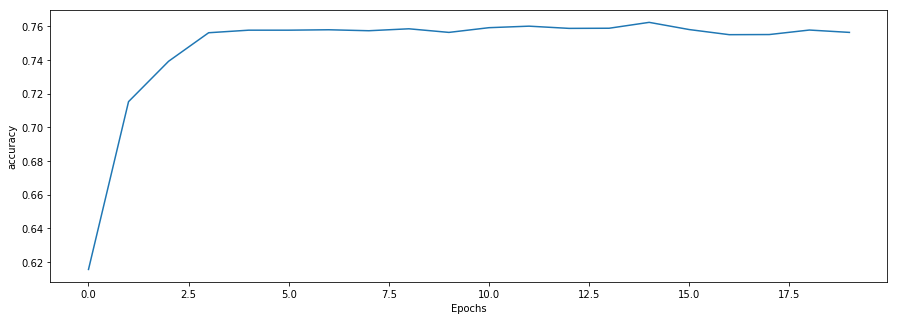

FOLD NUMBER:  6


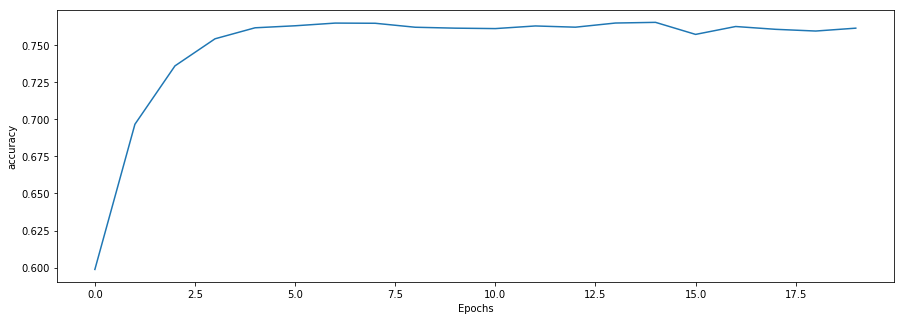

FOLD NUMBER:  7


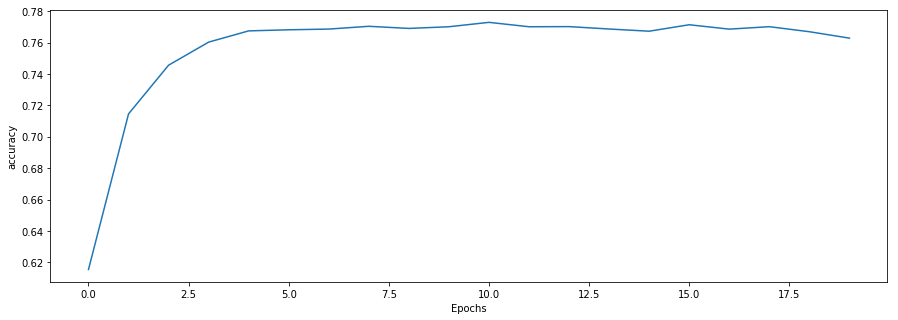

FOLD NUMBER:  8


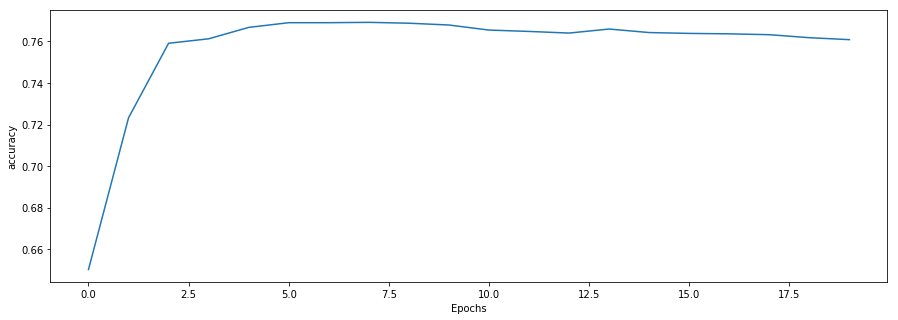

FOLD NUMBER:  9


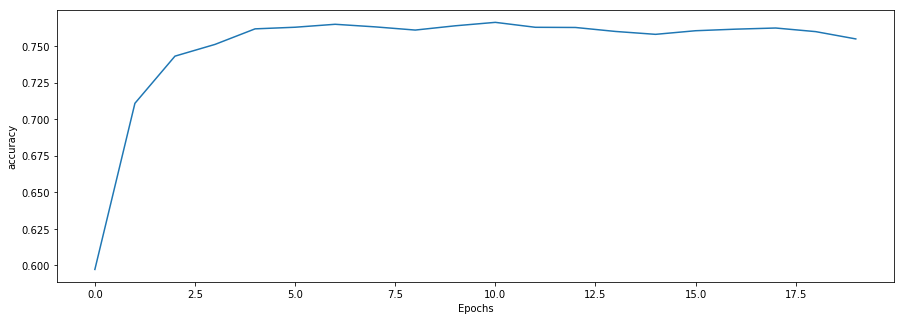

FOLD NUMBER:  10


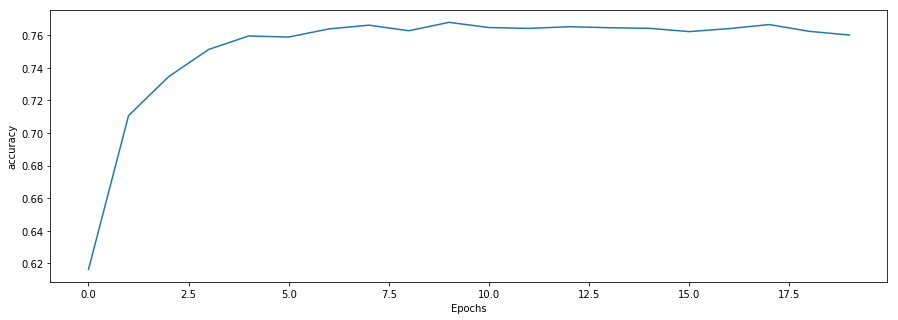

LOSS FOR EACH FOLD
FOLD NUMBER:  1


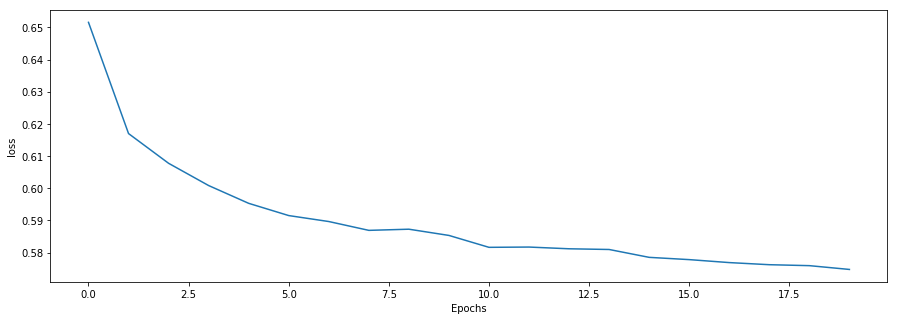

FOLD NUMBER:  2


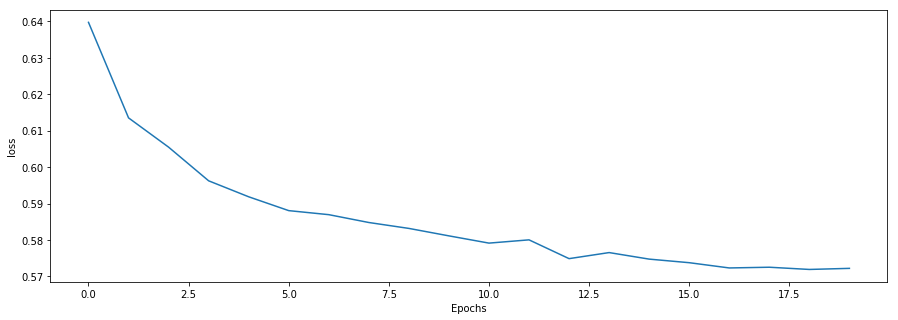

FOLD NUMBER:  3


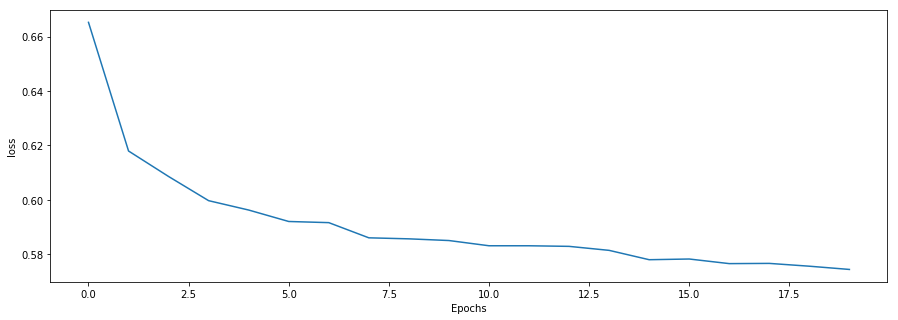

FOLD NUMBER:  4


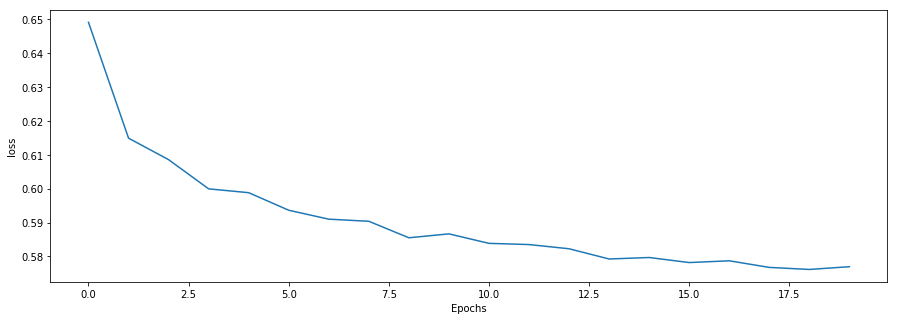

FOLD NUMBER:  5


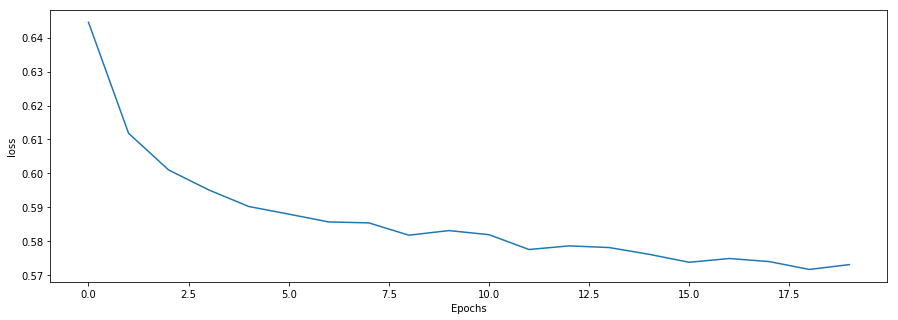

FOLD NUMBER:  6


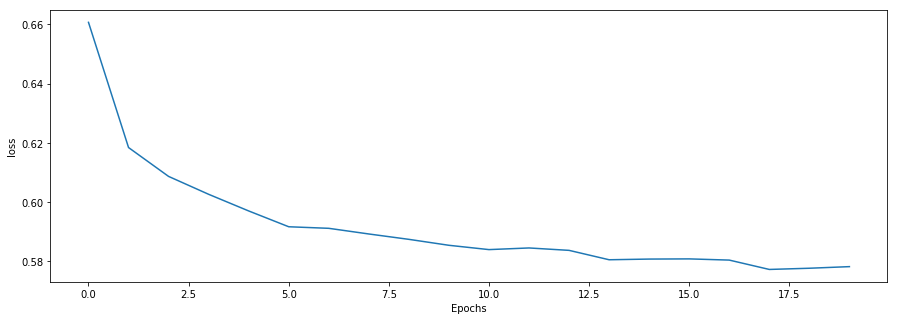

FOLD NUMBER:  7


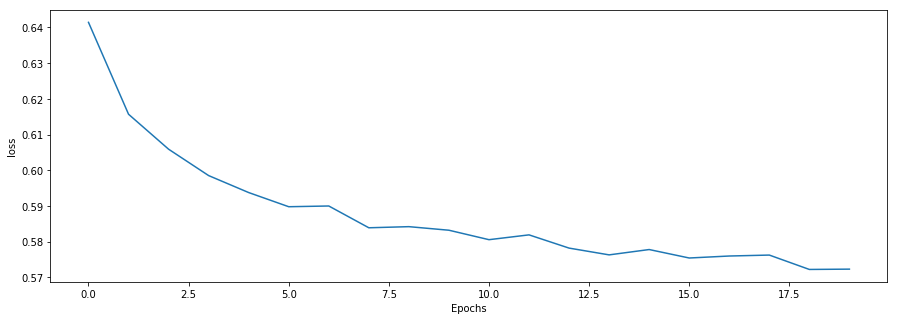

FOLD NUMBER:  8


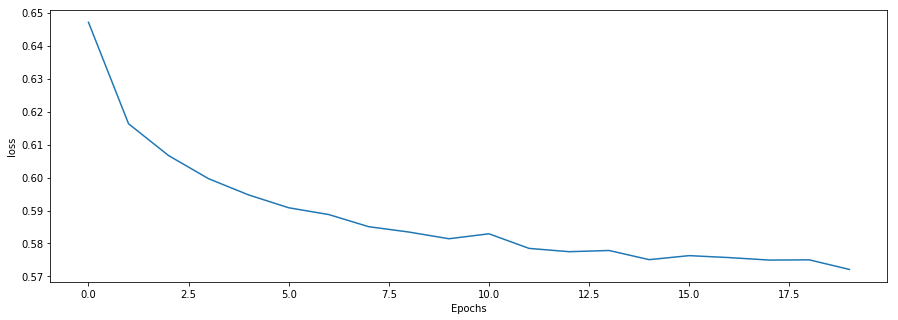

FOLD NUMBER:  9


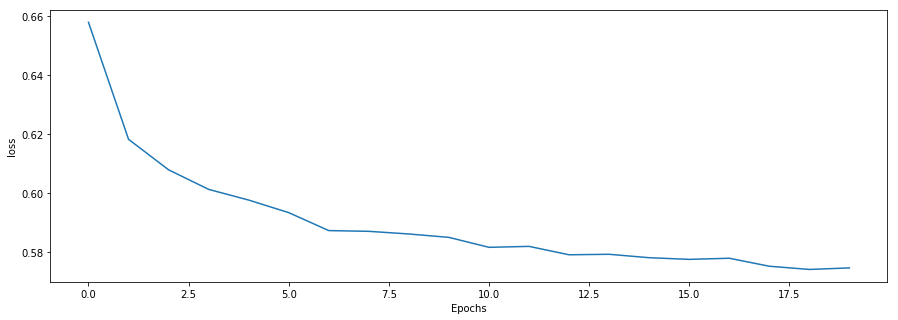

FOLD NUMBER:  10


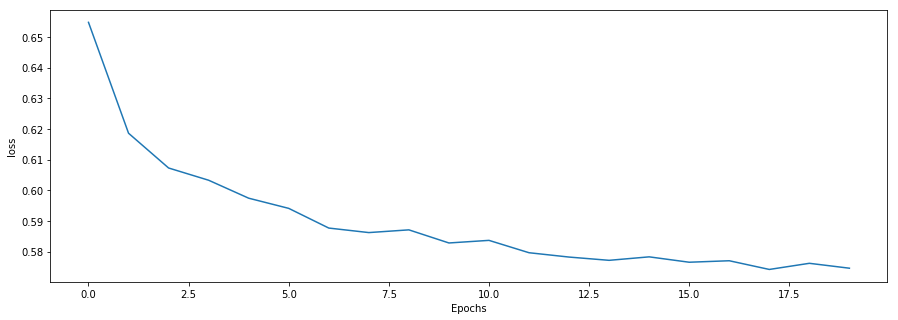

In [8]:
plt.figure(figsize=(8,8))
plt.plot(precision_0, label='Precision class 0')
plt.plot(precision_1, label='Precision class 1')
plt.title('Precision')
plt.legend(loc = 'best')
plt.show()

plt.figure(figsize=(8,8)) 
plt.plot(recall_0, label='Recall class 0')
plt.plot(recall_1, label='Recall class 1')
plt.title('Recall')
plt.legend(loc = 'best')
plt.show()

print("ACCURACY FOR EACH FOLD")
for fold in history_cross:
    print("FOLD NUMBER: ", history_cross.index(fold) + 1)
    plot_history(fold, 'accuracy')

print("LOSS FOR EACH FOLD")
for fold in history_cross:
    print("FOLD NUMBER: ", history_cross.index(fold) + 1)
    plot_history(fold, 'loss')

## Final Model
In this section i build the final model using all dataset available.

In [10]:
model = create_model()
class_weights = class_weight.compute_class_weight('balanced', np.unique(labels[train]), labels[train])
class_weights = dict(enumerate(class_weights))
history = model.fit(dataset, labels, class_weight = class_weights, epochs=20, batch_size=256, verbose=2)

Epoch 1/20
 - 0s - loss: 0.6495 - accuracy: 0.6111
Epoch 2/20
 - 0s - loss: 0.6168 - accuracy: 0.7117
Epoch 3/20
 - 0s - loss: 0.6036 - accuracy: 0.7470
Epoch 4/20
 - 0s - loss: 0.5990 - accuracy: 0.7519
Epoch 5/20
 - 0s - loss: 0.5941 - accuracy: 0.7616
Epoch 6/20
 - 0s - loss: 0.5887 - accuracy: 0.7630
Epoch 7/20
 - 0s - loss: 0.5884 - accuracy: 0.7613
Epoch 8/20
 - 0s - loss: 0.5871 - accuracy: 0.7635
Epoch 9/20
 - 0s - loss: 0.5848 - accuracy: 0.7622
Epoch 10/20
 - 0s - loss: 0.5828 - accuracy: 0.7673
Epoch 11/20
 - 0s - loss: 0.5813 - accuracy: 0.7630
Epoch 12/20
 - 0s - loss: 0.5822 - accuracy: 0.7650
Epoch 13/20
 - 0s - loss: 0.5790 - accuracy: 0.7673
Epoch 14/20
 - 0s - loss: 0.5775 - accuracy: 0.7651
Epoch 15/20
 - 0s - loss: 0.5775 - accuracy: 0.7610
Epoch 16/20
 - 0s - loss: 0.5778 - accuracy: 0.7610
Epoch 17/20
 - 0s - loss: 0.5745 - accuracy: 0.7621
Epoch 18/20
 - 0s - loss: 0.5730 - accuracy: 0.7646
Epoch 19/20
 - 0s - loss: 0.5750 - accuracy: 0.7617
Epoch 20/20
 - 0s - l

### Predict the test set label and save it in a file
I also count and show the number of label assign for each class

In [10]:
norm_testset, scaler2 = preprocess_data(testset) 
predictions = model.predict(norm_testset)
predictions_bool = (predictions>0.5)
print(predictions_bool[0:10])

[[ True]
 [False]
 [False]
 [ True]
 [ True]
 [ True]
 [False]
 [ True]
 [False]
 [False]]


In [11]:
count = collections.Counter(predictions_bool[:,0])
print(count)

Counter({False: 2082, True: 918})


In [12]:
count = collections.Counter(labels)
print(count)

Counter({0.0: 21027, 1.0: 5973})


In [13]:
result = open('./Giacomo_Villa_807462_score1.txt', 'w') 
for predict in predictions:
    if predict[0] > 0.5:
        result.write("1")
    else:
        result.write("0")
    result.write("\n")
result.close()